In [80]:
# run_with_new_generator_star.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

# Typography / plot style (legends are mechanism names only)
mpl.rc('font', family='serif', serif=['Times New Roman'])
mpl.rcParams.update({
    'text.usetex': False,
    'font.size': 16,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'figure.titlesize': 20,
})
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 30

# --- NEW: data utilities (star model) ---
from data_utils_newest import (
    gen_star_from_x1,       # <-- star/hub generator
    get_true_frequencies,
)

# --- baselines ---
from metrics import compute_mse
from spl import random_split_perturb, random_split_estimate
from rs_fd import rs_fd_perturb, rs_fd_estimate
from rs_rfd import rs_rfd_perturb, rs_rfd_estimate

from corr_rr_fixed_new import (
    corr_rr_phase1_spl,
    corr_rr_phase2_perturb,
    corr_rr_estimate,
    combine_phase_estimates,
    optimal_p_y,
    build_p_y_table,
)

# ---------------- helpers ----------------
def _normalize_dist(d):
    vals = np.array([max(0.0, float(v)) for v in d.values()], dtype=float)
    s = vals.sum()
    if s <= 0:
        k = len(vals)
        vals = np.full(k, 1.0 / k)
    else:
        vals = vals / s
    return {k: vals[i] for i, k in enumerate(d.keys())}

def _build_p_y_table_minimal(est_I, epsilon, n2, domain, cols):
    return {
        (a, b): float(optimal_p_y(est_I[a], est_I[b], epsilon, n2, domain))
        for a in cols for b in cols if a != b
    }

# ---------------- one-shot runner ----------------
def run_all_once(
    df,
    epsilon,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    cols = list(df.columns)
    domains = {c: sorted(df[c].unique().tolist()) for c in cols}
    true_freqs = get_true_frequencies(df, cols)

    out = {}

    # SPL
    rpt = random_split_perturb(df, epsilon)
    est = random_split_estimate(rpt, df, epsilon)
    out["SPL"] = np.mean([compute_mse(true_freqs[c], est[c]) for c in cols])

    # RS+FD
    pert_rsfd = rs_fd_perturb(df, domains, epsilon)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, epsilon)
    out["RS+FD"] = np.mean([compute_mse(true_freqs[c], est_rsfd[c]) for c in cols])

    # RS+RFD (two-phase)
    est_I_rsrfd, df_B_rsrfd, doms_rsrfd = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_rsrfd)
    n1_rsrfd = len(df) - len(df_B_rsrfd)
    n2_rsrfd = len(df_B_rsrfd)
    priors_2p = {col: _normalize_dist(est_I_rsrfd[col]) for col in est_I_rsrfd}
    pert_rsrfd_2p = rs_rfd_perturb(df_B_rsrfd, doms_rsrfd, priors_2p, epsilon)
    est_II_rsrfd = rs_rfd_estimate(pert_rsrfd_2p, doms_rsrfd, priors_2p, epsilon)
    combined_rsrfd = combine_phase_estimates(est_I_rsrfd, est_II_rsrfd, n1_rsrfd, n2_rsrfd)
    out["RS+RFD"] = np.mean([compute_mse(true_freqs[c], combined_rsrfd[c]) for c in cols])

    # Corr-RR
    if use_corr_rr:
        est_I, df_B, doms_stable = corr_rr_phase1_spl(df, epsilon, frac=frac_phase1_corr)
        n1 = len(df) - len(df_B)
        n2 = len(df_B)
        common_domain = doms_stable[cols[0]]
        p_y_table = _build_p_y_table_minimal(est_I, epsilon, n2, common_domain, cols)
        pert_corr = corr_rr_phase2_perturb(df_B, epsilon, est_I, doms_stable, p_y_table)
        est_II = corr_rr_estimate(pert_corr, doms_stable, epsilon)
        combined_est = combine_phase_estimates(est_I, est_II, n1, n2)
        out["Corr-RR"] = np.mean([compute_mse(true_freqs[c], combined_est[c]) for c in cols])

    return out

# ---------------- sweep & plot ----------------
def sweep_all(
    n=10000,
    epsilons=(0.2, 0.4, 0.6, 0.8, 1.0),
    R=50,
    corr=0.9,                 # global rho: every Xj (j>=2) correlates to X1
    d=4,                      # total attributes generated
    domain=None,
    x1_marginal=None,         # marginal p for X1 (and X1 only)
    q_marginal=None,          # None => uniform for non-copy branch
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    """
    Star model data: X1 ~ p; for j=2..d, Xj = X1 w.p. corr else ~ q.
    """
    if domain is None:
        domain = [0, 1]

    if x1_marginal is None:
        # default balanced marginal on the given domain
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(epsilons)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = d
    domain_size = len(domain)

    for run in range(R):
        # ---- NEW: star generator ----
        df = gen_star_from_x1(
            n=n,
            domain=domain,
            d=d,
            x1_marginal=x1_marginal,
            rho=corr,
            q_marginal=q_marginal,
            seed=None if seed is None else (seed + run + int(1000 * corr)),
        )

        for j, eps in enumerate(epsilons):
            res = run_all_once(
                df,
                eps,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res[k]

    for k in keys:
        means[k] /= R

    # Plot
    plt.figure(figsize=(10, 8))
    plt.plot(epsilons, means["SPL"],         '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(epsilons, means["RS+FD"],       '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(epsilons, means["RS+RFD"],      '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(epsilons, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')
    print(means["Corr-RR"])
    plt.xlabel(r'$ϵ$', fontsize=50)
    plt.ylabel('MSE',  fontsize=40)
    plt.xticks(epsilons, labels=[str(e) for e in epsilons])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='best', frameon=True, edgecolor='black')
    plt.tight_layout()

    # Output filenames
    def _fmt(x): return f"{x:g}"
    base = f"mseVSrho_{attr_count}attr_{domain_size}domain_n_{n}_frac_{_fmt(frac_phase1_rsrfd)}_rho_{_fmt(corr)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"epsilon": list(epsilons)})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    return means




In [7]:
def sweep_vs_rho(
    n=10000,
    rhos=(0.1, 0.3, 0.5, 0.7, 0.9),   # x-axis: correlation values to test
    epsilon=0.8,                      # fixed epsilon
    R=50,
    d=4,
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    """
    Star model data: X1 ~ p; for j=2..d, Xj = X1 w.p. rho else ~ q.
    X-axis: rho (correlation); Y-axis: MSE.
    """
    if domain is None:
        domain = [0, 1]
    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(rhos)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = d
    domain_size = len(domain)

    for run in range(R):
        for j, rho in enumerate(rhos):
            # generate a fresh dataset for this rho
            df = gen_star_from_x1(
                n=n,
                domain=domain,
                d=d,
                x1_marginal=x1_marginal,
                rho=rho,
                q_marginal=q_marginal,
                seed=None if seed is None else (seed + run + int(1000 * rho)),
            )

            res = run_all_once(
                df,
                epsilon,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res.get(k, 0.0)

    for k in keys:
        means[k] /= R

    # ----- Plot (exactly same style as your epsilon sweep) -----
    plt.figure(figsize=(10, 8))
    plt.plot(rhos, means["SPL"],    '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(rhos, means["RS+FD"],  '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(rhos, means["RS+RFD"], '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(rhos, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')
        print(means["Corr-RR"])

    plt.xlabel(r'$\rho$', fontsize=50)
    plt.ylabel('MSE',     fontsize=40)
    plt.xticks(rhos, labels=[str(r) for r in rhos])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='upper right', frameon=True, edgecolor='black')
    plt.tight_layout()

    # Filenames
    def _fmt(x): return f"{x:g}"
    base = f"mseVSrho_{attr_count}attr_{domain_size}domain_n_{n}_eps_{_fmt(epsilon)}_frac_{_fmt(frac_phase1_rsrfd)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"rho": list(rhos)})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    return means


[0.00248801 0.00042202]


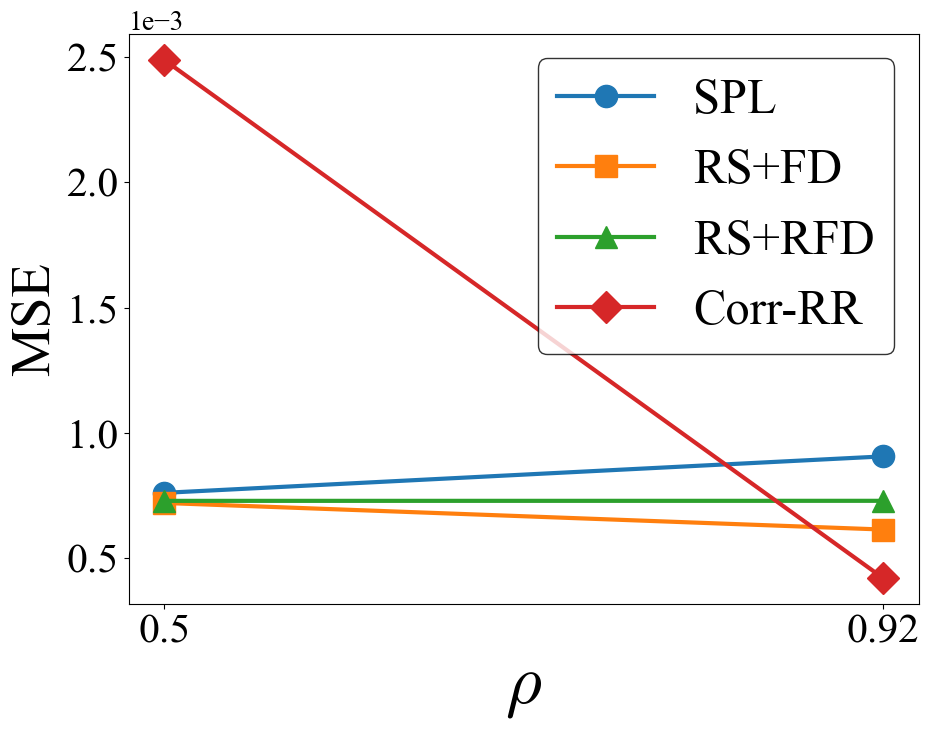

In [34]:
if __name__ == "__main__":
    rhos = [0.5, 0.92]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 2
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=20,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        #plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        #csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


[0.00065204]


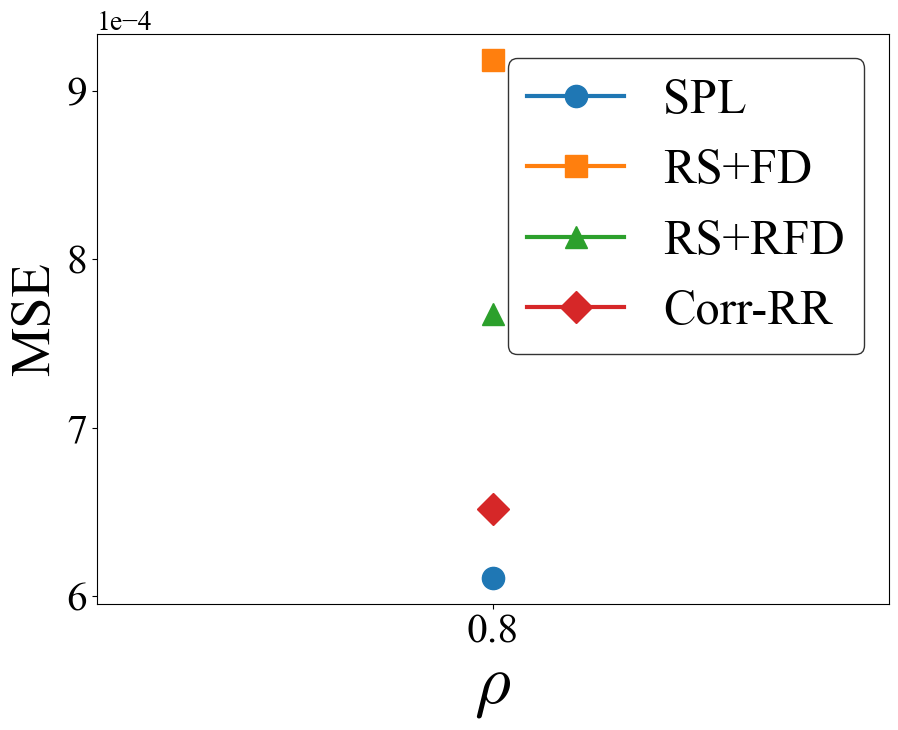

In [35]:
if __name__ == "__main__":
    rhos = [0.8]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 2
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=20,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        #plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        #csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


[0.00503304 0.00259164]


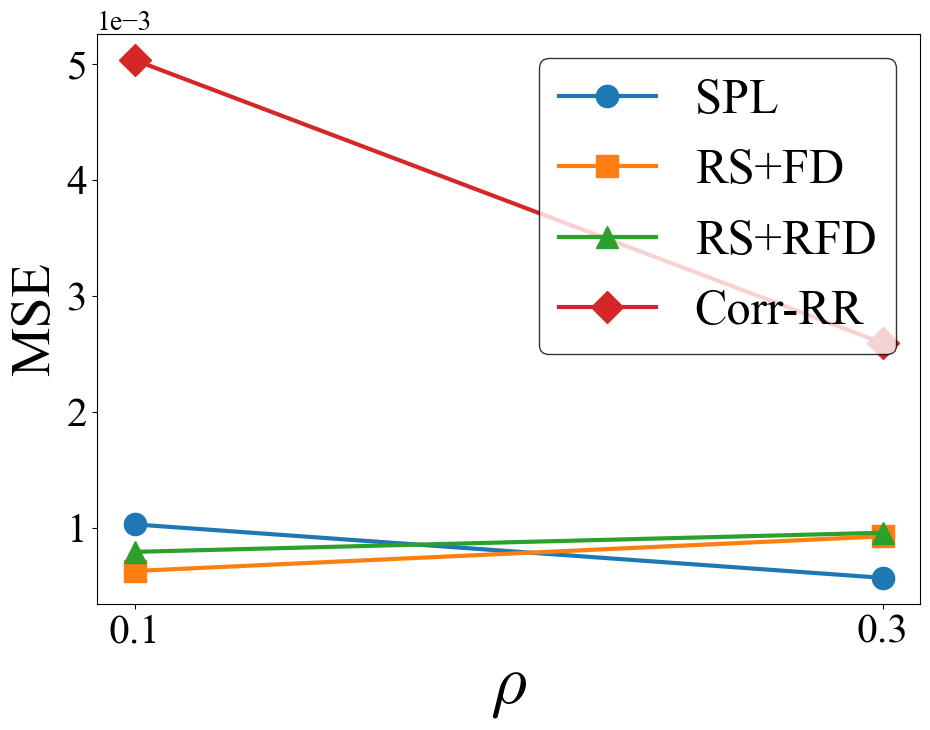

In [36]:
if __name__ == "__main__":
    rhos = [0.1, 0.3]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 2
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=20,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        #plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        #csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


[0.00553372 0.00136695]


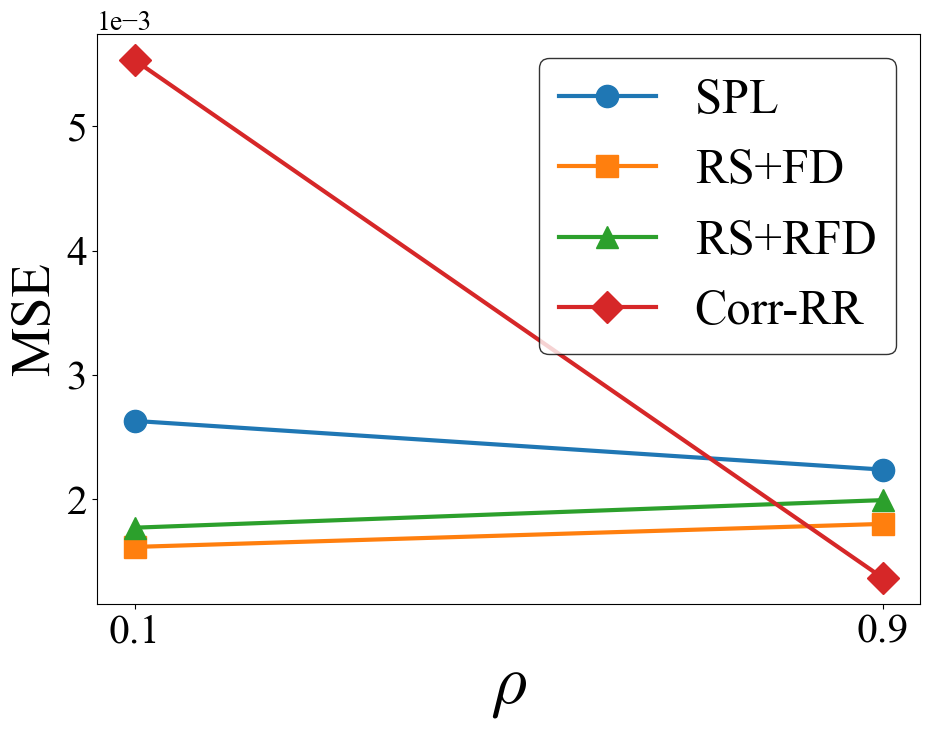

In [37]:
if __name__ == "__main__":
    rhos = [0.1, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 2
    eps_fixed = 0.3
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=20,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        #plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        #csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


[0.01330091 0.01822023]


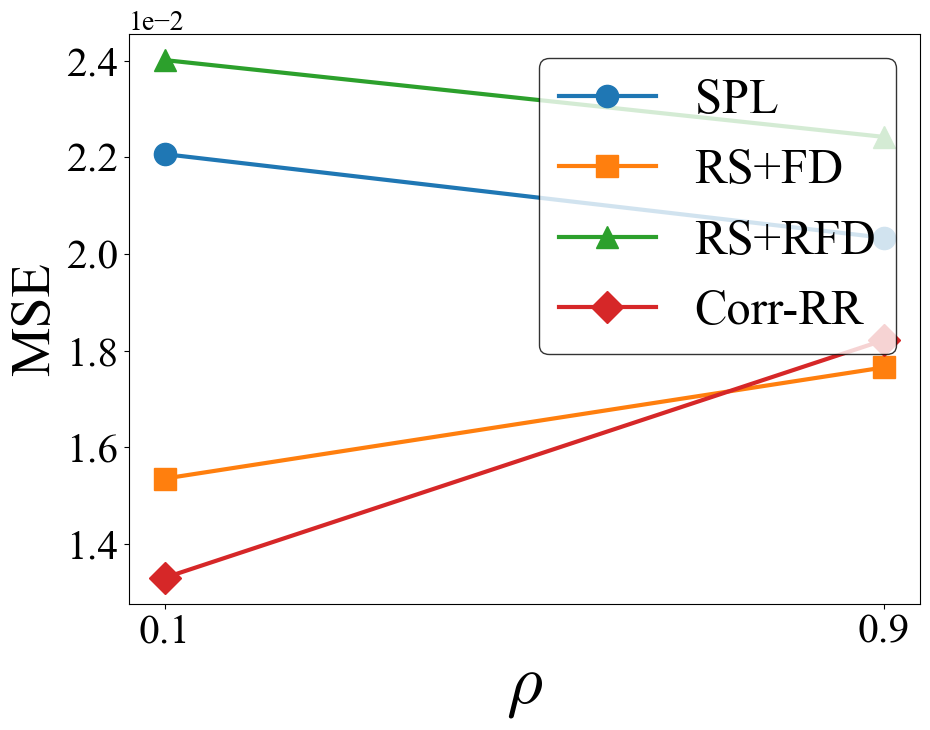

In [38]:
if __name__ == "__main__":
    rhos = [0.1, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 2
    eps_fixed = 0.1
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=20,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        #plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        #csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


[0.0055367  0.00219384 0.0027041 ]


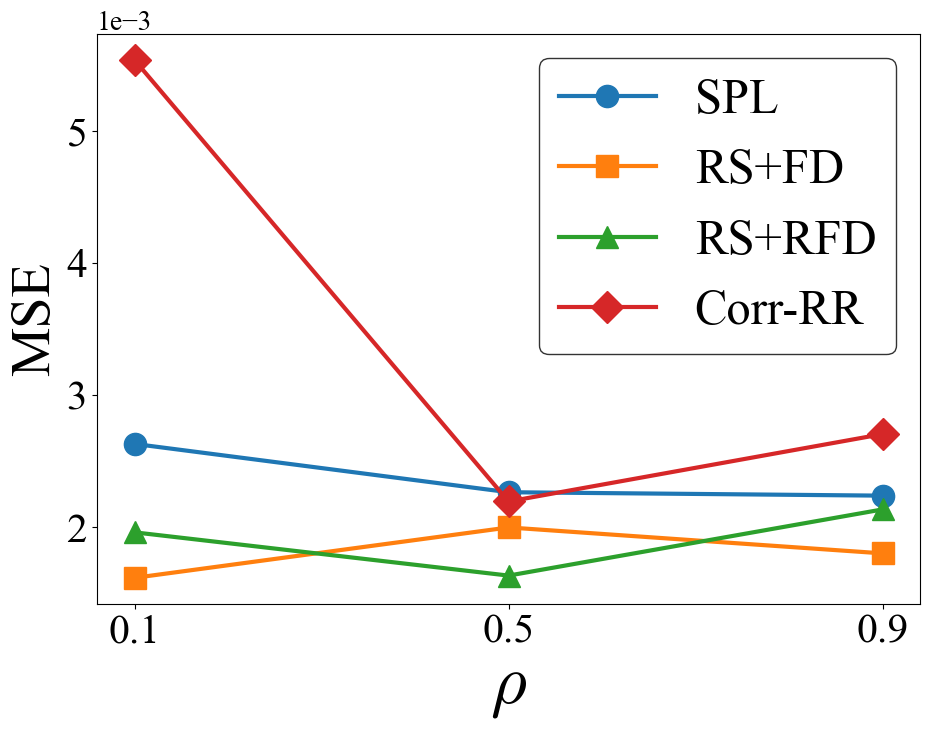

In [41]:
if __name__ == "__main__":
    rhos = [0.1, 0.5, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 2
    eps_fixed = 0.3
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=20,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        #plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        #csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


[0.00384375 0.00246762 0.00142742 0.00166938 0.00027577]


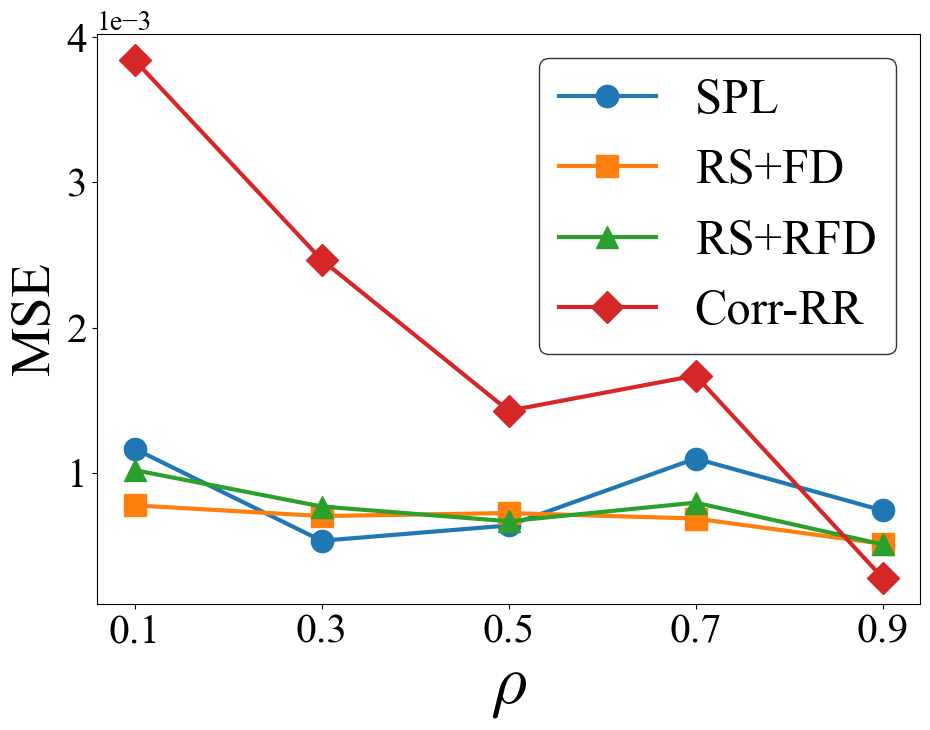

In [43]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 2
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=10,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        #plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        #csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


[0.00597758 0.00550925 0.00441423 0.00202719 0.0009379 ]


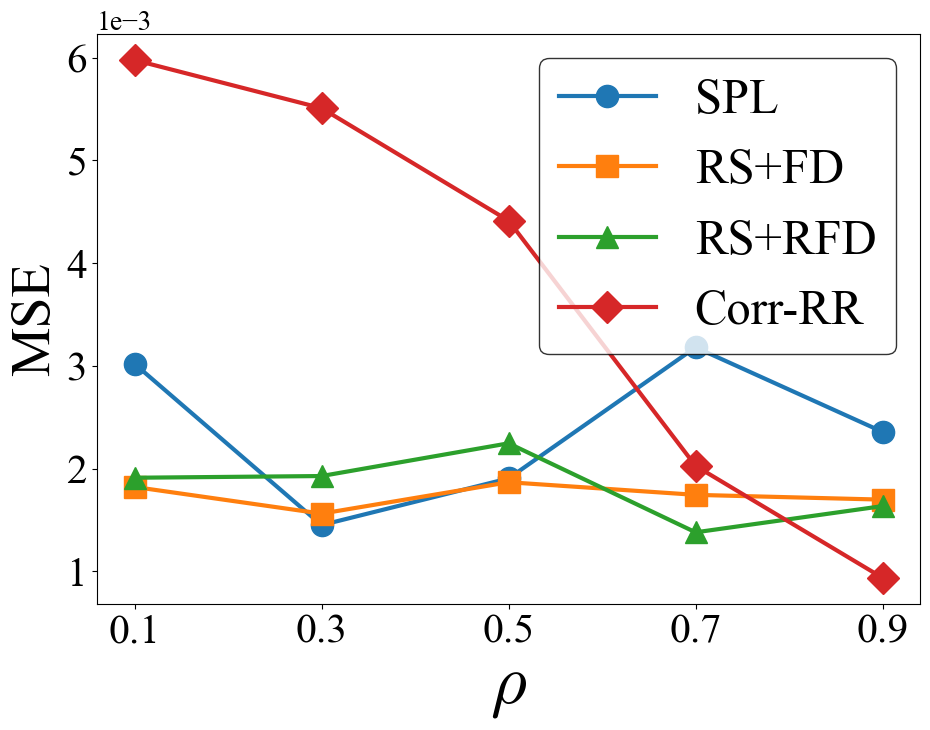

In [44]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 2
    eps_fixed = 0.3
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=10,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        #plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        #csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


[0.02165715 0.02054071 0.00811629 0.01214191 0.01543254]


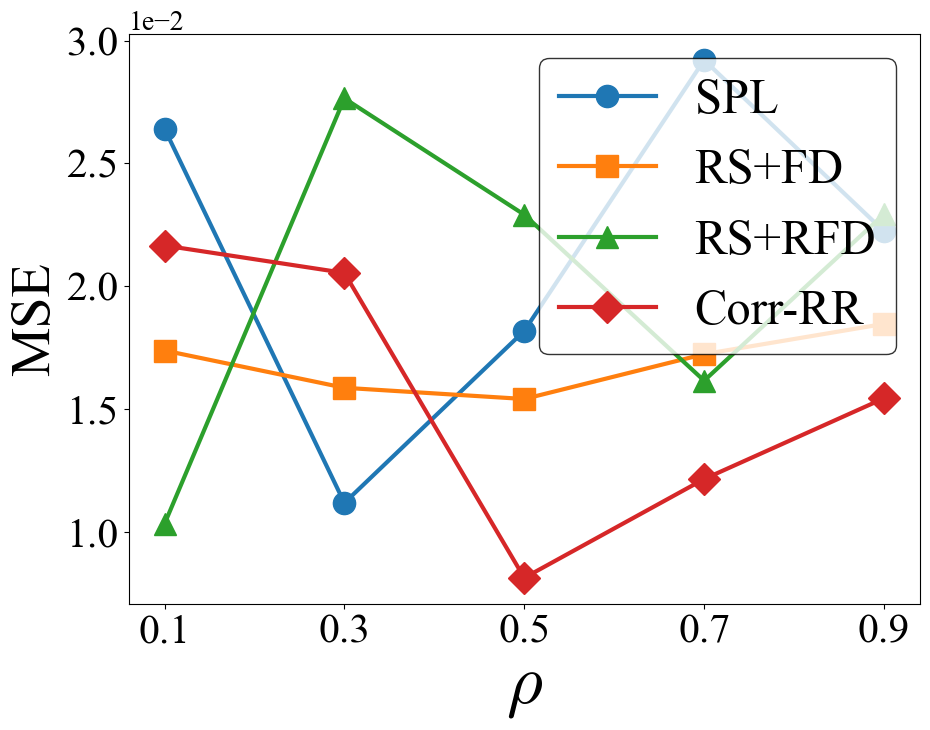

In [46]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 2
    eps_fixed = 0.1
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=10,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        #plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        #csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


[0.00600347 0.00477024 0.00400388 0.00096934 0.00042821]


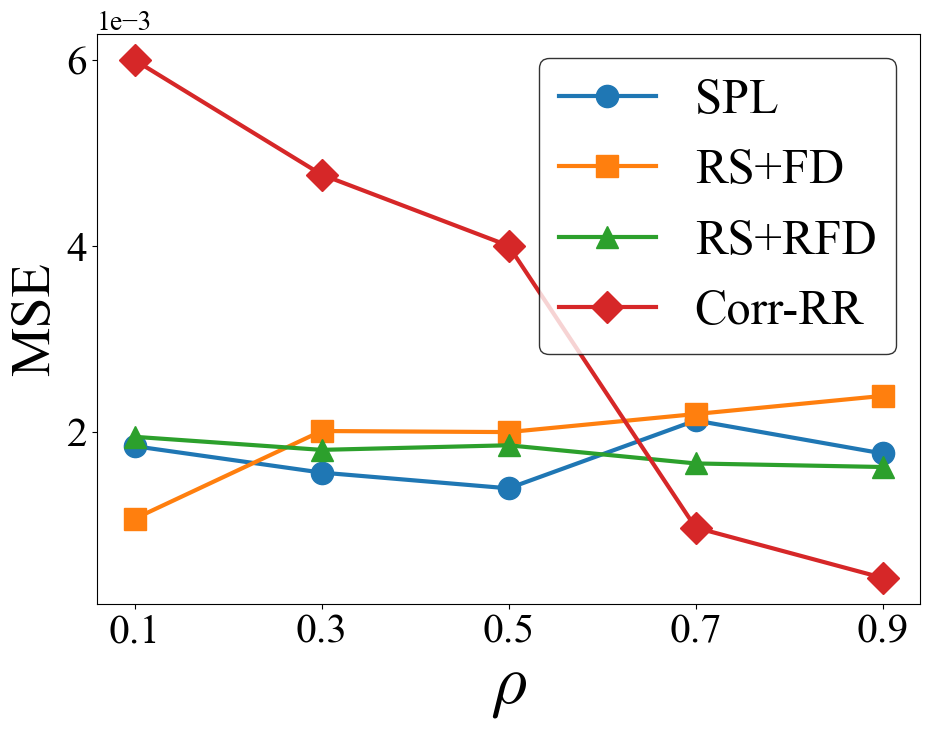

In [49]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 3
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=10,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        #plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig",
        #csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/fig/data",
    )


[0.00472082 0.0029575  0.0021842  0.00094931 0.00049778]


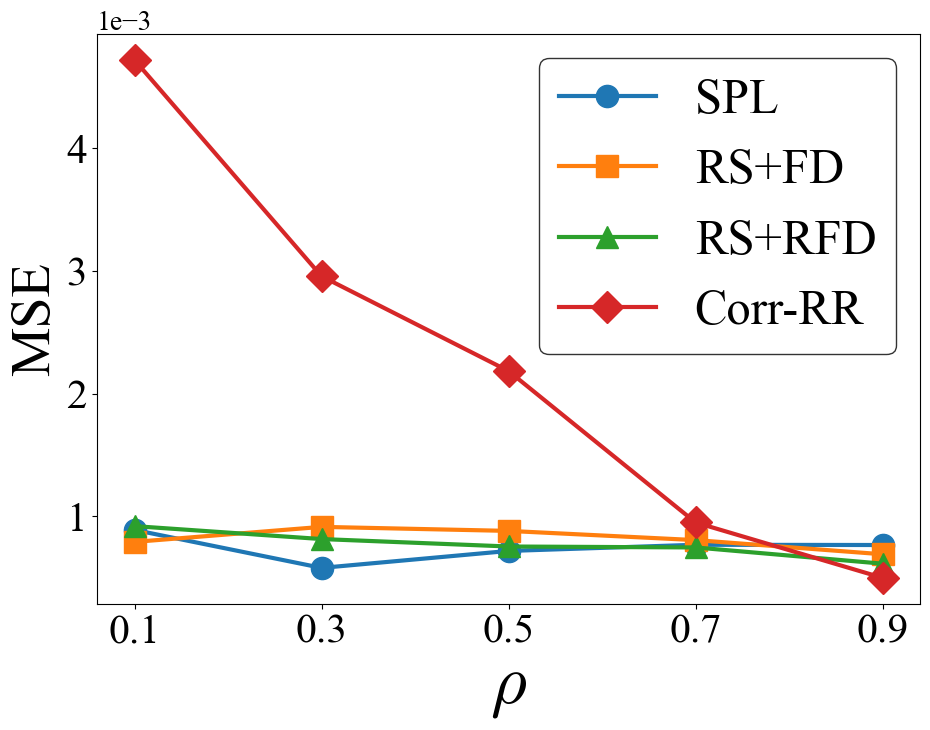

In [59]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 2
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=50,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00524478 0.0049559  0.00417155 0.00399912 0.00162854]


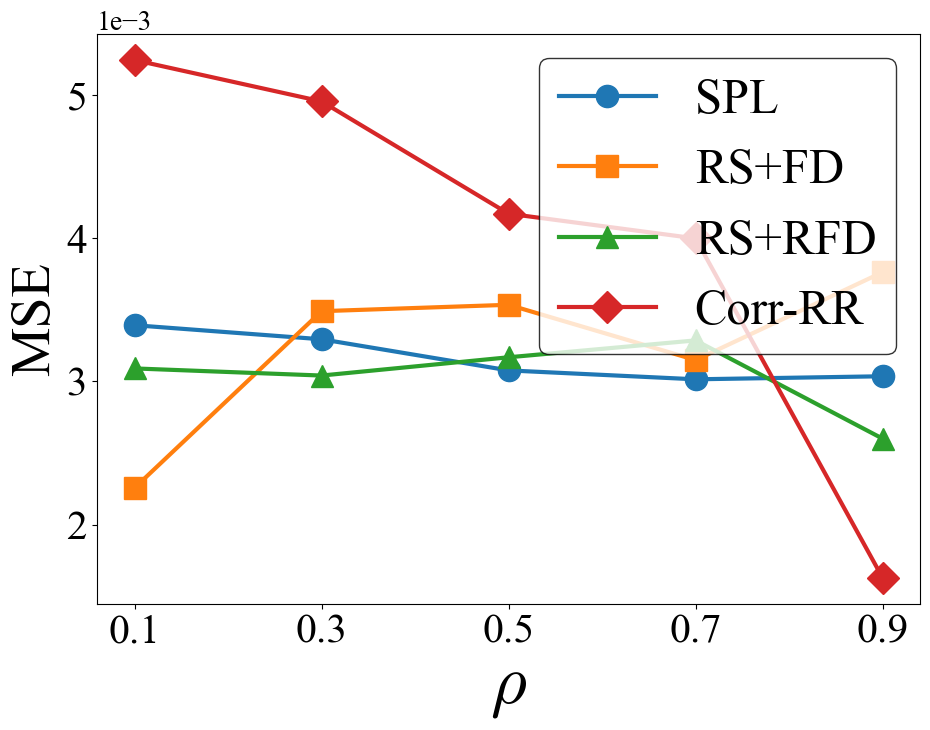

In [60]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 4
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=50,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00511076 0.00566227 0.0046072  0.00358916 0.00245391]


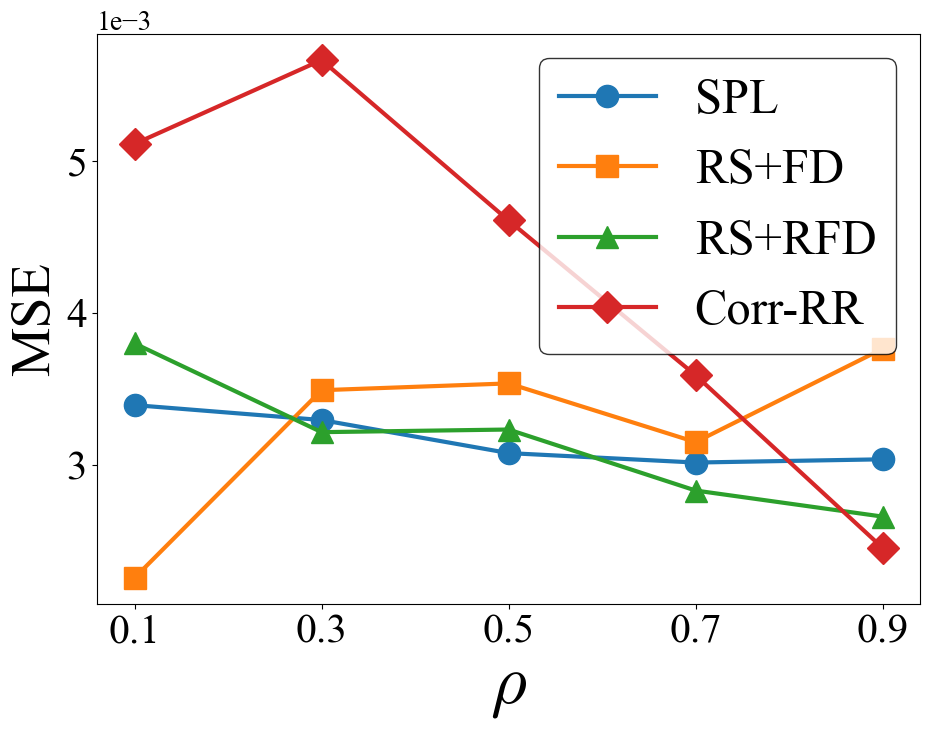

In [62]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 4
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=50,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.4,
        frac_phase1_rsrfd=0.4,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00730421 0.00617174 0.00365364 0.00159633 0.00071089]


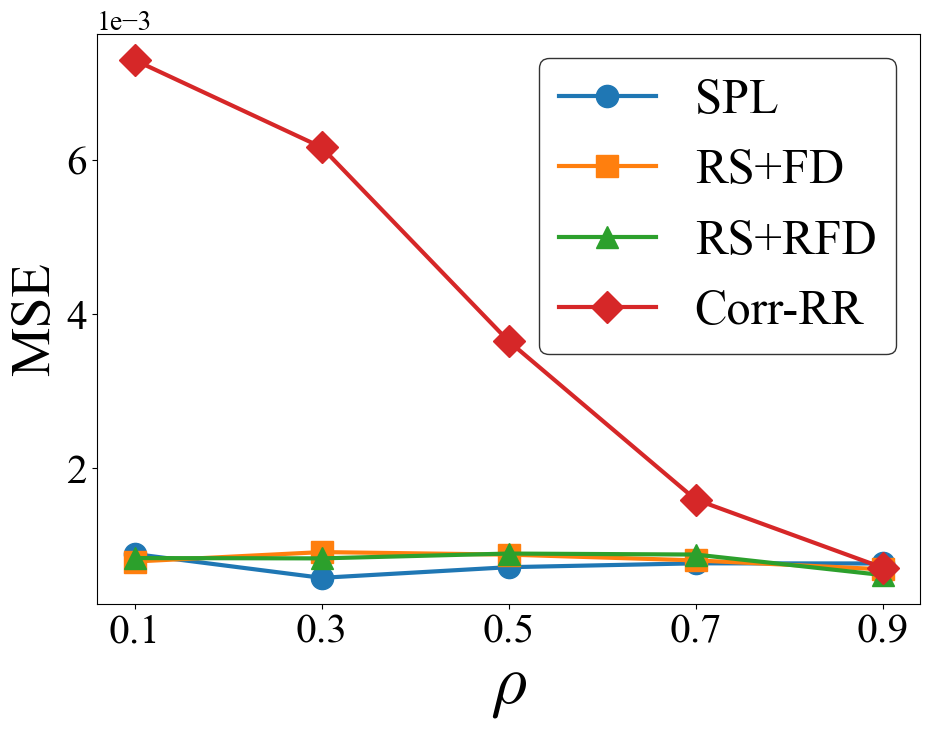

In [63]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 2
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=50,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00697291 0.00596693 0.00570675 0.00456664 0.00267162]


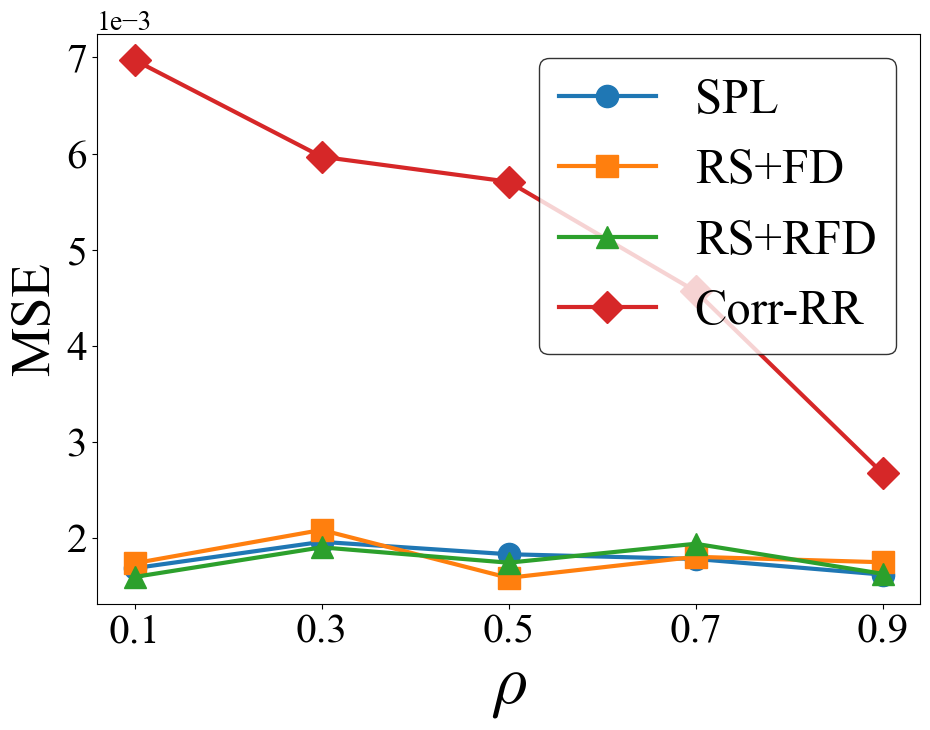

In [64]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 3
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=50,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00627002 0.00607637 0.00658934 0.00766269 0.00585722]


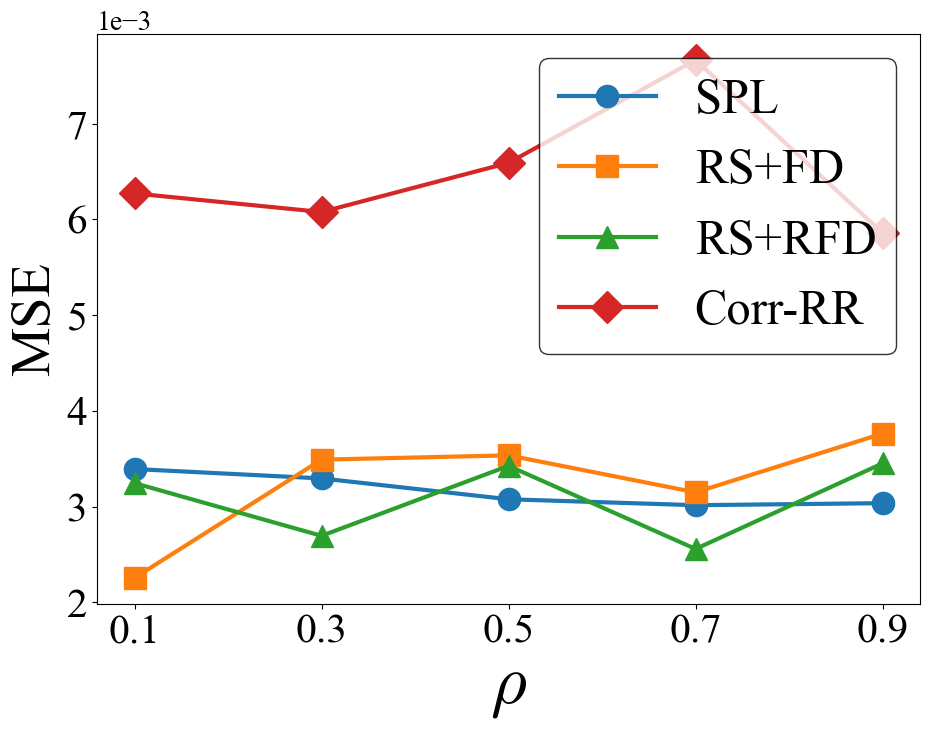

In [65]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.7, 1:0.3}
    d = 4
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=50,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00169532 0.00115609 0.00101241 0.00075538 0.00059909]


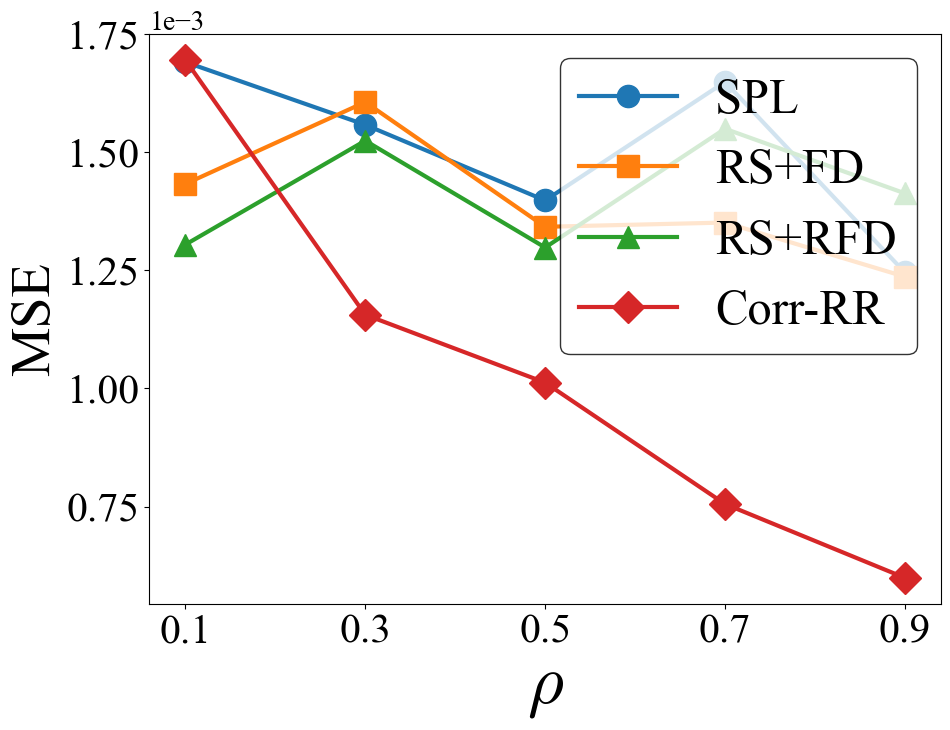

In [66]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1,2]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.4, 1:0.3, 2:0.2}
    d = 2
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=50,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00120571 0.00152304 0.00080933 0.00150852 0.00091341]


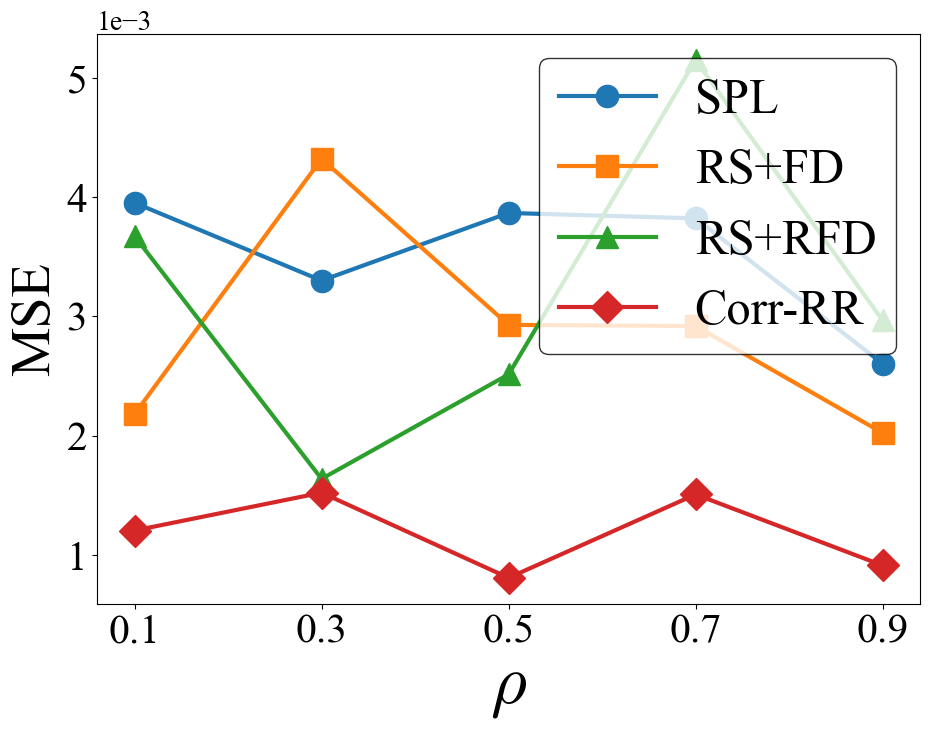

In [67]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1,2]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.4, 1:0.3, 2:0.2}
    d = 3
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=5,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00249919 0.0023145  0.00145089 0.00193141 0.00129403]


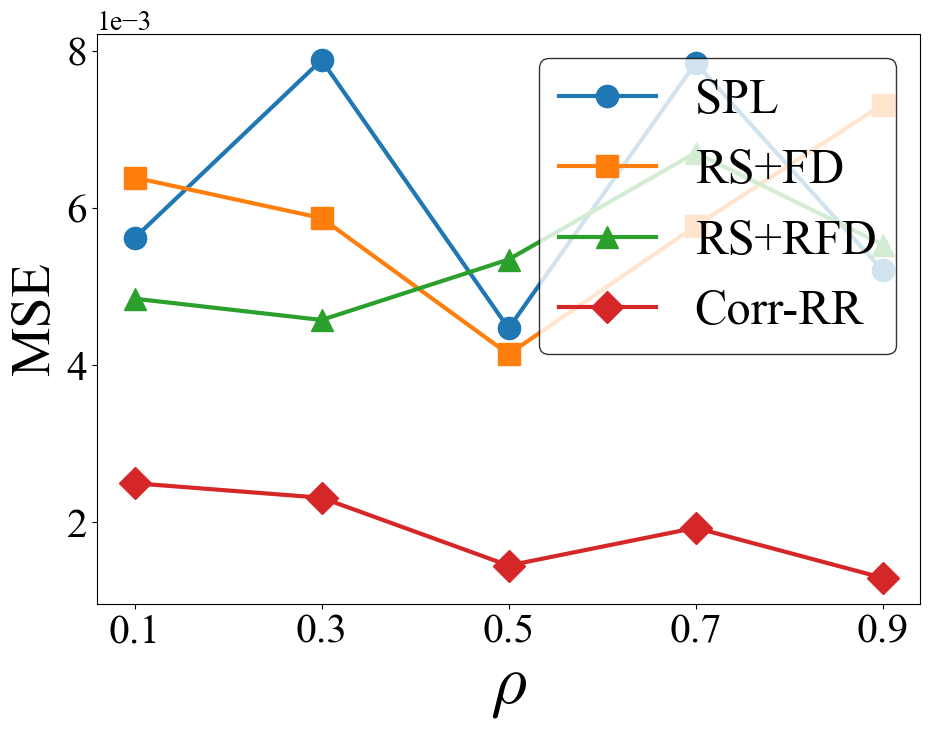

In [68]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1,2]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.4, 1:0.3, 2:0.2}
    d = 4
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=5,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00166436 0.00101634 0.00111793 0.00045161 0.00022007]


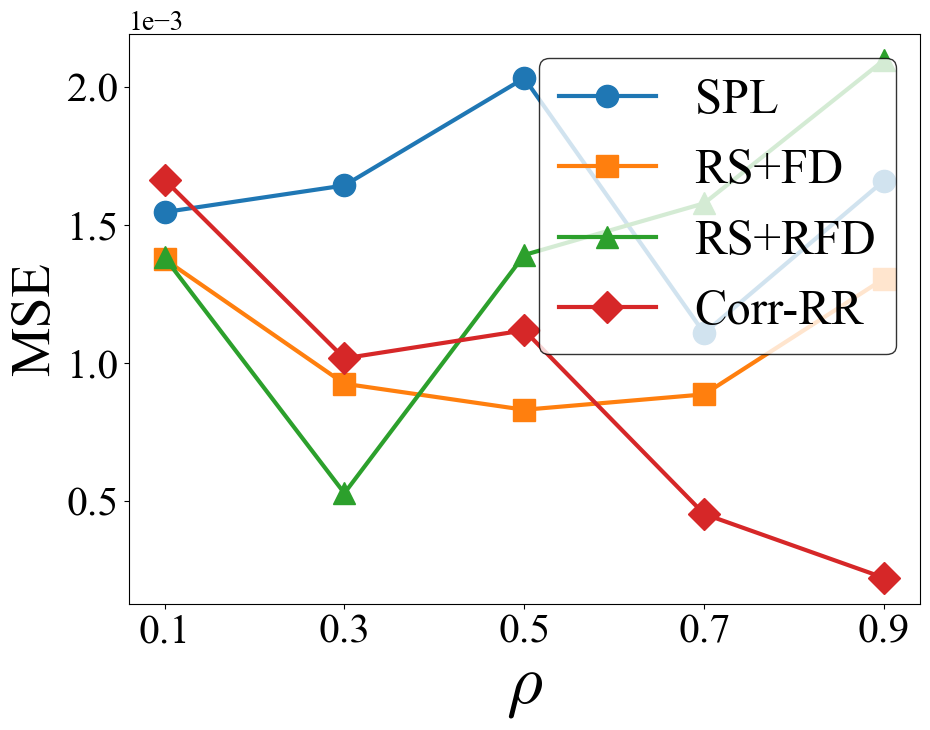

In [69]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1,2]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.4, 1:0.3, 2:0.2}
    d = 2
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=5,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.1,
        frac_phase1_rsrfd=0.1,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00151992 0.00124078 0.0013385  0.00097342 0.00074069]


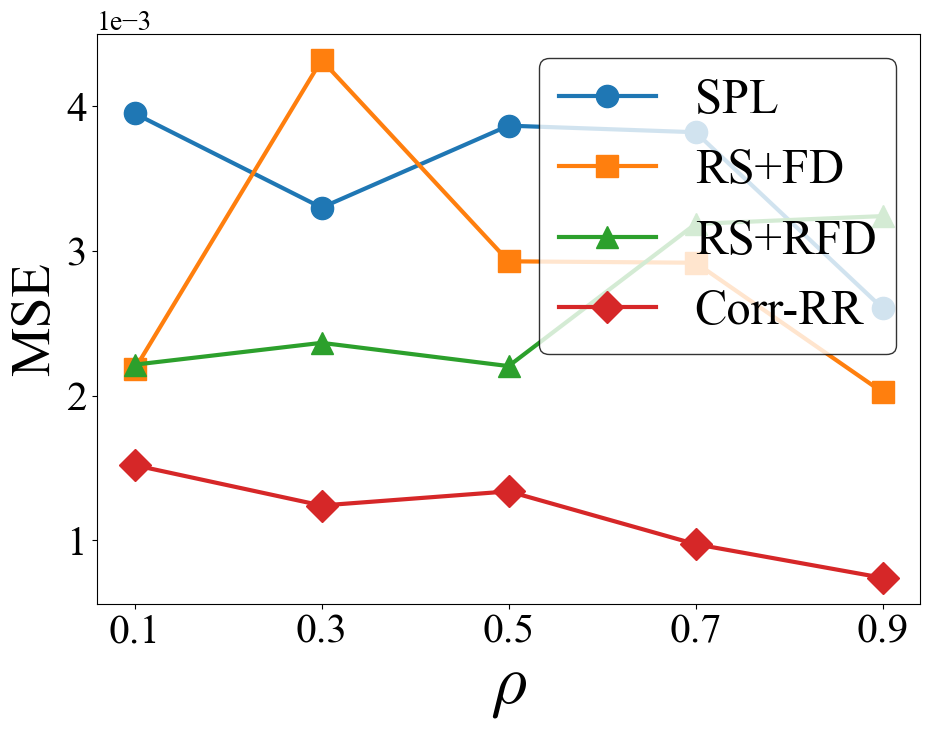

In [70]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1,2]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.4, 1:0.3, 2:0.2}
    d = 3
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=5,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.1,
        frac_phase1_rsrfd=0.1,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00210015 0.00307511 0.00174654 0.00176505 0.00186583]


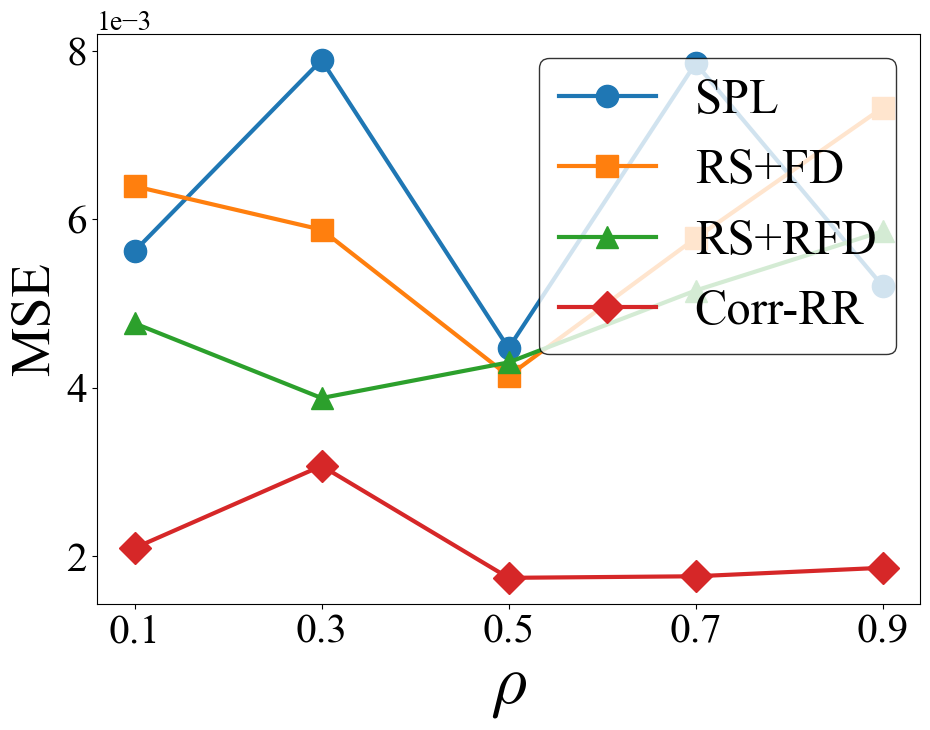

In [71]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5,0.7, 0.9]

    domain = [0,1,2]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.4, 1:0.3, 2:0.2}
    d = 4
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=5,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.1,
        frac_phase1_rsrfd=0.1,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00270891 0.0006604 ]


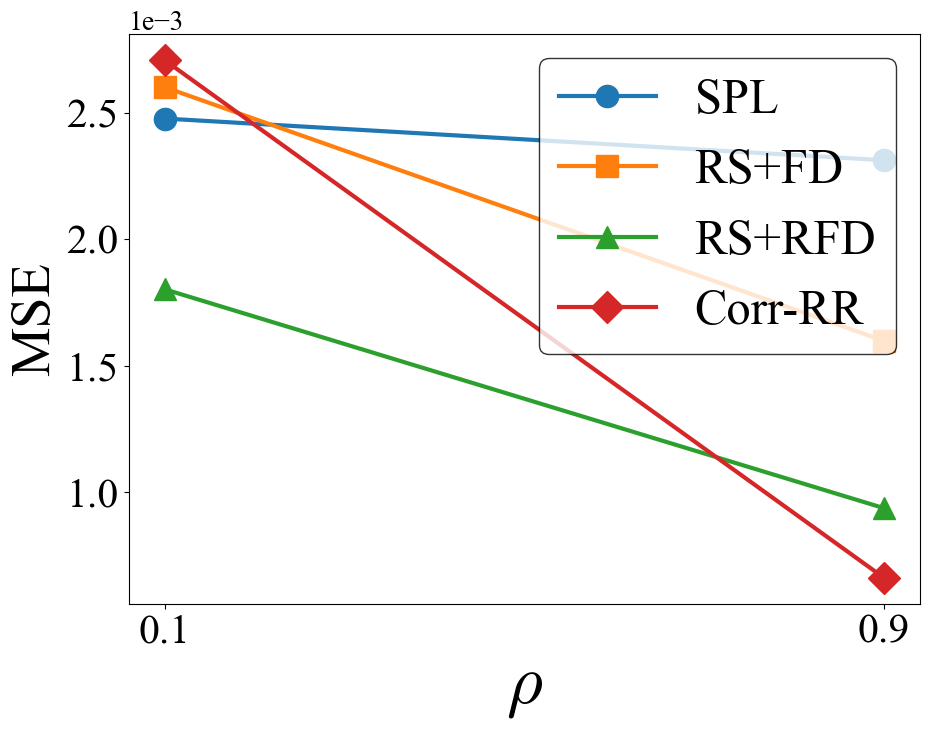

In [74]:
if __name__ == "__main__":
    rhos = [0.1, 0.9]

    domain = [0,1,2, 3]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    d = 2
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=3,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.3,
        frac_phase1_rsrfd=0.3,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


[0.00242184 0.00198869]


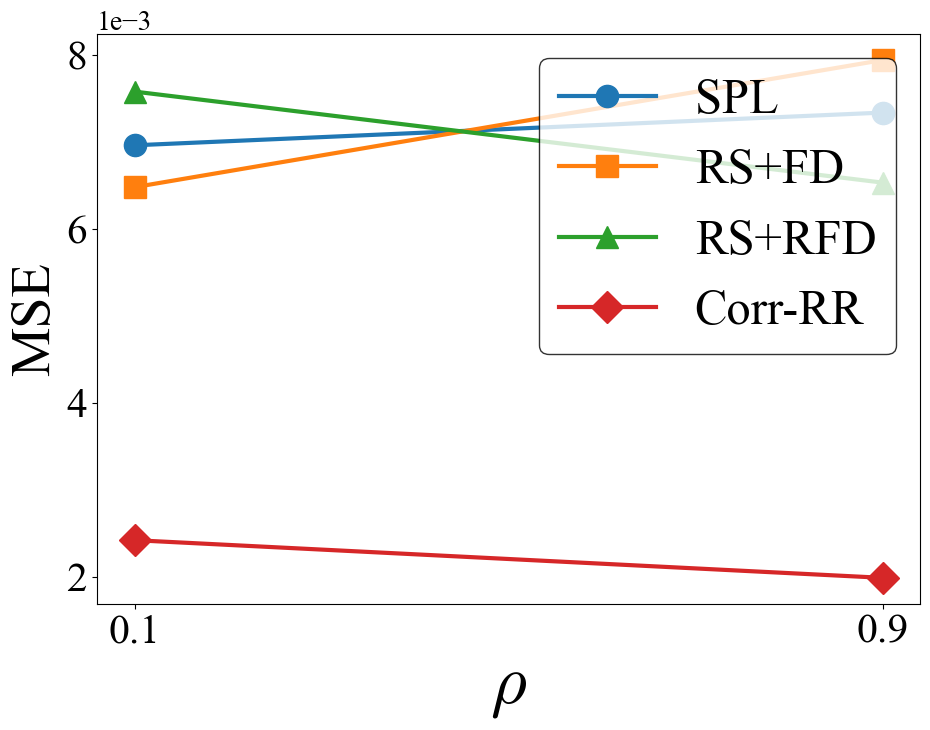

In [75]:
if __name__ == "__main__":
    rhos = [0.1, 0.9]

    domain = [0,1,2, 3]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    d = 4
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=3,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data",
    )


In [85]:
def sweep_vs_rho(
    n=10000,
    rhos=(0.1, 0.3, 0.5, 0.7, 0.9),   # x-axis: correlation values to test
    epsilon=0.8,                      # fixed epsilon
    R=50,
    d=4,
    domain=None,
    x1_marginal=None,
    q_marginal=None,
    plot_dir=None,
    csv_dir=None,
    seed=None,
    use_corr_rr=True,
    frac_phase1_corr=0.1,
    frac_phase1_rsrfd=0.1,
):
    """
    Star model data: X1 ~ p; for j=2..d, Xj = X1 w.p. rho else ~ q.
    X-axis: rho (correlation); Y-axis: MSE.
    """
    if domain is None:
        domain = [0, 1]
    if x1_marginal is None:
        x1_marginal = {v: 1.0 / len(domain) for v in domain}

    keys = ["SPL", "RS+FD", "RS+RFD"] + (["Corr-RR"] if use_corr_rr else [])
    means = {k: np.zeros(len(rhos)) for k in keys}

    if seed is not None:
        np.random.seed(seed)

    attr_count = d
    domain_size = len(domain)

    for run in range(R):
        for j, rho in enumerate(rhos):
            # generate a fresh dataset for this rho
            df = gen_star_from_x1(
                n=n,
                domain=domain,
                d=d,
                x1_marginal=x1_marginal,
                rho=rho,
                q_marginal=q_marginal,
                seed=None if seed is None else (seed + run + int(1000 * rho)),
            )

            res = run_all_once(
                df,
                epsilon,
                use_corr_rr=use_corr_rr,
                frac_phase1_corr=frac_phase1_corr,
                frac_phase1_rsrfd=frac_phase1_rsrfd,
            )
            for k in keys:
                means[k][j] += res.get(k, 0.0)

    for k in keys:
        means[k] /= R

    # ----- Plot (exactly same style as your epsilon sweep) -----
    plt.figure(figsize=(10, 8))
    plt.plot(rhos, means["SPL"],    '-o', linewidth=3, markersize=16, label='SPL')
    plt.plot(rhos, means["RS+FD"],  '-s', linewidth=3, markersize=16, label='RS+FD')
    plt.plot(rhos, means["RS+RFD"], '-^', linewidth=3, markersize=16, label='RS+RFD')
    if use_corr_rr:
        plt.plot(rhos, means["Corr-RR"], '-D', linewidth=3, markersize=16, label='Corr-RR')
        print(means["Corr-RR"])

    plt.xlabel(r'$\rho$', fontsize=50)
    plt.ylabel('MSE',     fontsize=40)
    plt.xticks(rhos, labels=[str(r) for r in rhos])
    plt.tick_params(axis='both', which='major', labelsize=30)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    plt.legend(fontsize=35, loc='best', frameon=True, edgecolor='black')
    plt.tight_layout()

    # Filenames
    def _fmt(x): return f"{x:g}"
    base = f"Final_mseVSrho_{attr_count}attr_{domain_size}domain_n_{n}_eps_{_fmt(epsilon)}_frac_{_fmt(frac_phase1_rsrfd)}"

    if plot_dir:
        os.makedirs(plot_dir, exist_ok=True)
        plt.savefig(os.path.join(plot_dir, base + ".pdf"), format="pdf")

    plt.show()

    if csv_dir:
        os.makedirs(csv_dir, exist_ok=True)
        df_out = pd.DataFrame({"rho": list(rhos)})
        for k in keys:
            df_out[k] = means[k]
        df_out.to_csv(os.path.join(csv_dir, base + ".csv"), index=False)

    return means


[0.00243308 0.00159825 0.00123218 0.00093768 0.00092644]


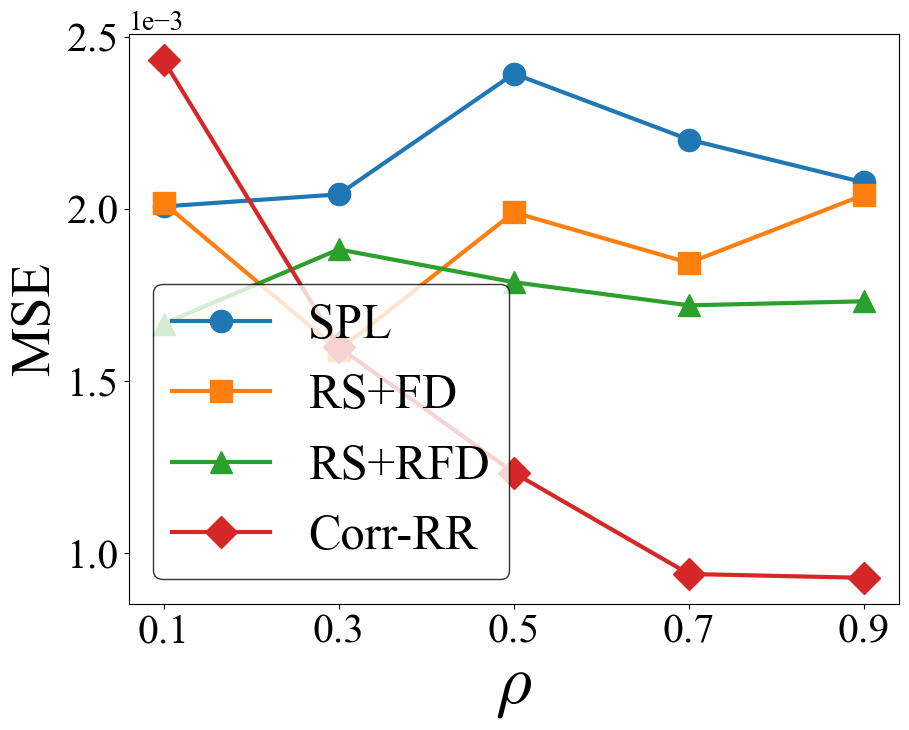

In [86]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5, 0.7, 0.9]

    domain = [0,1,2, 3]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    d = 2
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=200,
        rhos=rhos,
        epsilon=eps_fixed,
        R=50,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/main",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data/main",
    )


[0.00275958 0.002299   0.00182972 0.00148402 0.00129894]


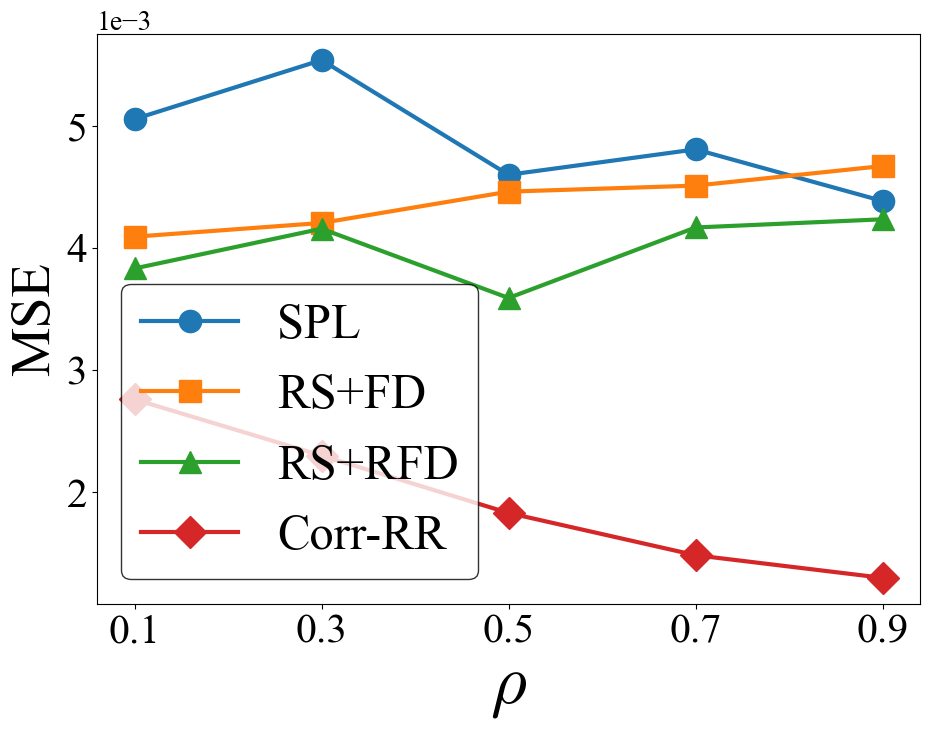

In [87]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5, 0.7, 0.9]

    domain = [0,1,2, 3]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    d = 3
    eps_fixed = 0.5
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=50,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/main",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data/main",
    )


[0.00266346 0.00240064 0.00191448 0.00140114 0.00167332]


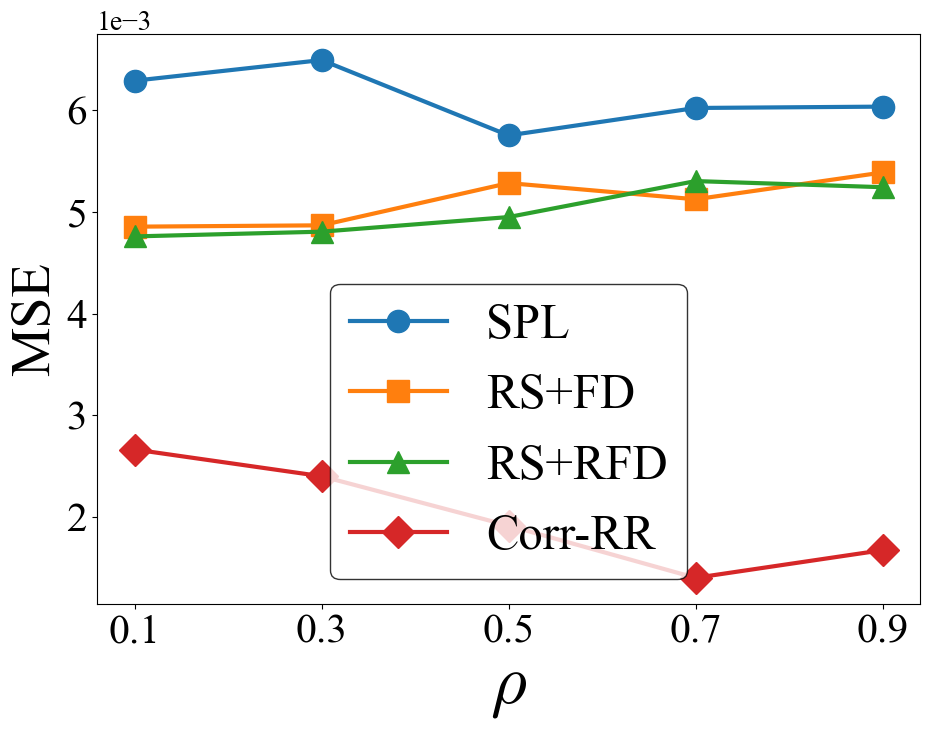

In [89]:
if __name__ == "__main__":
    rhos = [0.1, 0.3, 0.5, 0.7, 0.9]

    domain = [0,1,2, 3]
    #x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    x1_marginal = {0:0.4, 1:0.3, 2:0.2, 3:0.1}
    d = 4
    eps_fixed = 0.6
    q = None

    means_rho = sweep_vs_rho(
        n=20000,
        rhos=rhos,
        epsilon=eps_fixed,
        R=50,
        d=d,
        domain=domain,
        x1_marginal=x1_marginal,
        q_marginal=q,
        seed=42,
        use_corr_rr=True,
        frac_phase1_corr=0.2,
        frac_phase1_rsrfd=0.2,
        plot_dir="/Users/shafizurrahmanseeam/Desktop/cs/main",
        csv_dir="/Users/shafizurrahmanseeam/Desktop/cs/data/main",
    )
